# Deep Reinforcement Learning Laboratory

In this laboratory session we will work on getting more advanced versions of Deep Reinforcement Learning algorithms up and running. Deep Reinforcement Learning is **hard**, and getting agents to stably train can be frustrating and requires quite a bit of subtlety in analysis of intermediate results. We will start by refactoring (a bit) my implementation of `REINFORCE` on the [Cartpole environment](https://gymnasium.farama.org/environments/classic_control/cart_pole/).

### Import the packages

In [8]:
%%capture
!apt install python-opengl
!apt install ffmpeg
!apt install xvfb
!pip install pyvirtualdisplay
!pip install pyglet==1.5.1
!pip install gym_pygame

In [33]:
import numpy as np

from collections import deque

import matplotlib.pyplot as plt
%matplotlib inline

import imageio
from PIL import Image

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

# Gym
import gymnasium as gym

import wandb
import copy
import random

## Exercise 1: Improving my `REINFORCE` Implementation (warm up)

In this exercise we will refactor a bit and improve some aspects of my `REINFORCE` implementation.

### The CartPole environment

In [11]:
# Virtual display
from pyvirtualdisplay import Display
from IPython.display import Video, display

virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

In [12]:
env_id = "CartPole-v1"

env = gym.make(env_id)

eval_env = gym.make(env_id)

s_size = env.observation_space.shape[0]
a_size = env.action_space.n

In [13]:
print("_____OBSERVATION SPACE_____ \n")
print("The State Space is: ", s_size)
print("Sample observation", env.observation_space.sample()) # Get a random observation

_____OBSERVATION SPACE_____ 

The State Space is:  4
Sample observation [ 4.172828    0.6731989  -0.23019499 -1.2372632 ]


In [14]:
print("\n _____ACTION SPACE_____ \n")
print("The Action Space is: ", a_size)
print("Action Space Sample", env.action_space.sample()) # Take a random action


 _____ACTION SPACE_____ 

The Action Space is:  2
Action Space Sample 0


### Reinforce Architecture

> ⚠️ **Disclaimer**  
> L'implementazione riportata di seguito si basa su una combinazione di risorse pubblicamente disponibili e suggerite dal corso **Deep Reinforcement Learning with Hugging Face**. In particolare, il codice e i concetti sono stati ispirati e adattati da:
>
> - [Esempio ufficiale PyTorch REINFORCE](https://github.com/pytorch/examples/blob/main/reinforcement_learning/reinforce.py)  
> - [Implementazione REINFORCE di Udacity](https://github.com/udacity/deep-reinforcement-learning/blob/master/reinforce/REINFORCE.ipynb)  
> - [Pull Request di ottimizzazione di Chris1nexus](https://github.com/huggingface/deep-rl-class/pull/95)
>
> In particolare, l'efficiente calcolo del **reward-to-go** è stato adattato dal lavoro di [Chris1nexus](https://github.com/Chris1nexus), il cui codice e spiegazioni sono ben documentati nella [pull request](https://github.com/huggingface/deep-rl-class/pull/95) al corso Hugging Face.
>
> Queste fonti sono state selezionate tra quelle raccomandate nel modulo dedicato alla policy gradient del corso, e hanno fornito una base solida sia dal punto di vista teorico che implementativo.

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit6/reinforce.png" alt="Reinforce"/>


In [15]:
class Policy(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

### Reinforce Training

In [16]:
class ReinforceTrainer:
    def __init__(self, policy, optimizer, env, gamma=0.99, max_t=1000, project_name=None):
        self.policy = policy
        self.optimizer = optimizer
        self.env = env
        self.gamma = gamma
        self.max_t = max_t
        self.project_name = project_name

        self.scores = []
        self.scores_deque = deque(maxlen=100)
        self.best_score = -float('inf')

        if self.project_name:
            wandb.init(project=self.project_name)

    def compute_returns(self, rewards):
        returns = deque(maxlen=self.max_t)
        for t in reversed(range(len(rewards))):
            R = rewards[t] + self.gamma * (returns[0] if returns else 0.0)
            returns.appendleft(R)
        returns = torch.tensor(returns)
        eps = np.finfo(np.float32).eps.item()
        return (returns - returns.mean()) / (returns.std() + eps)

    def reinforce(self, num_episodes=500, print_every=50, save_path="best_reinforce.pt"):
        for i_episode in range(1, num_episodes + 1):
            saved_log_probs = []
            rewards = []
            # Gymnasium reset returns a tuple (observation, info), we only need the observation
            state, _ = self.env.reset()

            for t in range(self.max_t):
                action, log_prob = self.policy.act(state)
                saved_log_probs.append(log_prob)
                # Gymnasium step returns (observation, reward, terminated, truncated, info)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                rewards.append(reward)
                done = terminated or truncated # In Gymnasium, done is terminated or truncated
                state = next_state # Update state for the next iteration
                if done:
                    break

            total_reward = sum(rewards)
            self.scores.append(total_reward)
            self.scores_deque.append(total_reward)

            returns = self.compute_returns(rewards)

            policy_loss = [-log_prob * R for log_prob, R in zip(saved_log_probs, returns)]
            policy_loss = torch.cat(policy_loss).sum()

            self.optimizer.zero_grad()
            policy_loss.backward()
            self.optimizer.step()

            avg_score = np.mean(self.scores_deque)

            if self.project_name:
                wandb.log({
                    'episode': i_episode,
                    'reward': total_reward,
                    'avg_reward': avg_score
                })

            if avg_score > self.best_score:
                self.best_score = avg_score
                torch.save(self.policy.state_dict(), save_path)
                if self.project_name:
                    wandb.run.summary["best_avg_reward"] = avg_score

            if i_episode % print_every == 0:
                print(f"Episode {i_episode}\tAverage Score: {avg_score:.2f}")

        self.plot_rewards(self.scores) # Use self.scores which is accumulated over all episodes

        return self.scores

    def plot_rewards(self, reward_list, window=100):
          plt.figure(figsize=(12, 6))
          plt.plot(reward_list, label='Reward per Episode')

          if len(reward_list) >= window:
              moving_avg = np.convolve(reward_list, np.ones(window)/window, mode='valid')
              plt.plot(range(window - 1, len(reward_list)), moving_avg, label=f'{window}-Episode Moving Avg', linewidth=2)

          plt.xlabel('Episode')
          plt.ylabel('Reward')
          plt.title('Training Progress')
          plt.legend()
          plt.grid(True)
          plt.show()

In [17]:
def evaluate_agent(env, max_steps, n_eval_episodes, policy):
    """
    Evaluate the agent for `n_eval_episodes` episodes and return the average and standard deviation of rewards.

    :param env: The evaluation environment (gym.Env)
    :param max_steps: Maximum number of steps per episode
    :param n_eval_episodes: Number of episodes to evaluate the agent
    :param policy: The Reinforce policy with an `act(state)` method
    :return: Tuple of (mean_reward, std_reward)
    """
    episode_rewards = []

    for episode in range(n_eval_episodes):
        state, _ = env.reset()  # Gymnasium reset returns (obs, info)
        total_rewards_ep = 0

        for step in range(max_steps):
            action, _ = policy.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            total_rewards_ep += reward
            done = terminated or truncated

            if done:
                break
            state = next_state

        episode_rewards.append(total_rewards_ep)

    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    return mean_reward, std_reward


In [31]:
def record_video(env, policy, out_path, fps=30):
    """
    Record a video of an agent acting in an environment.
    :param env: the environment with render_mode='rgb_array'
    :param policy: the agent, must implement policy.act(state)
    :param out_path: full path to output .mp4 or .gif
    :param fps: frames per second
    """
    images = []
    state, _ = env.reset()
    done = False

    img = env.render()
    images.append(img)

    while not done:
        action, _ = policy.act(state)
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        img = env.render()
        images.append(img)

    imageio.mimsave(out_path, [np.array(img) for img in images], fps=fps)
    print(f"Video saved to {out_path}")
    display(Video(out_path, embed=True))

In [20]:
cartpole_hyperparameters = {
    "h_size": 16,
    "n_training_episodes": 600,
    "n_evaluation_episodes": 10,
    "max_t": 1000,
    "gamma": 1.0,
    "lr": 1e-2,
    "env_id": env_id,
    "state_space": s_size,
    "action_space": a_size,
}

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Episode 10	Average Score: 19.40
Episode 20	Average Score: 21.30
Episode 30	Average Score: 19.53
Episode 40	Average Score: 21.25
Episode 50	Average Score: 23.44
Episode 60	Average Score: 24.85
Episode 70	Average Score: 27.09
Episode 80	Average Score: 28.00
Episode 90	Average Score: 31.98
Episode 100	Average Score: 37.46
Episode 110	Average Score: 51.93
Episode 120	Average Score: 73.21
Episode 130	Average Score: 83.54
Episode 140	Average Score: 93.34
Episode 150	Average Score: 103.78
Episode 160	Average Score: 116.47
Episode 170	Average Score: 129.33
Episode 180	Average Score: 145.86
Episode 190	Average Score: 176.77
Episode 200	Average Score: 218.09
Episode 210	Average Score: 248.21
Episode 220	Average Score: 272.90
Episode 230	Average Score: 298.66
Episode 240	Average Score: 336.22
Episode 250	Average Score: 372.56
Episode 260	Average Score: 402.52
Episode 270	Average Score: 435.61
Episode 280	Average Score: 465.64
Episode 290	Average Score: 478.35
Episode 300	Average Score: 478.35
Epi

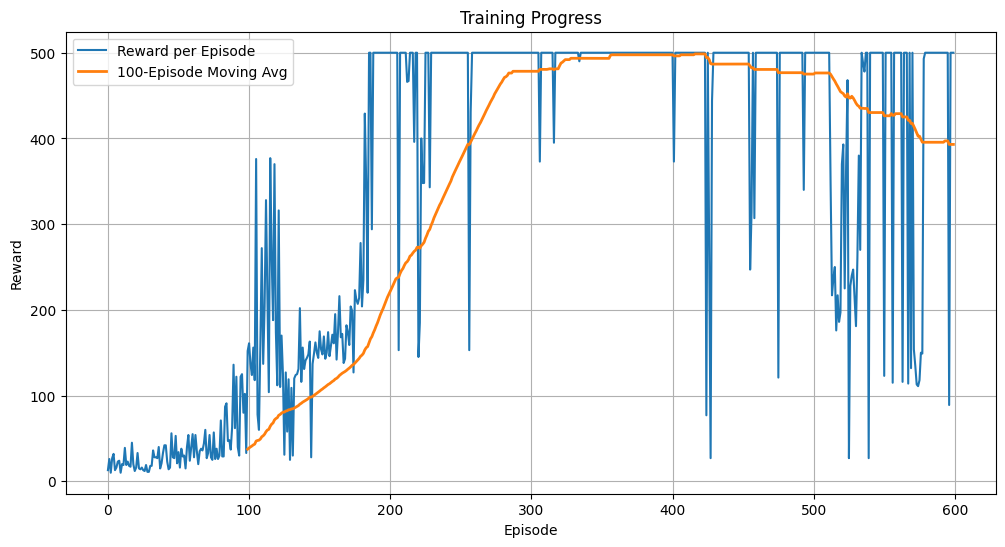

In [22]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
policy = Policy(cartpole_hyperparameters["state_space"], cartpole_hyperparameters["action_space"], cartpole_hyperparameters["h_size"]).to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

trainer = ReinforceTrainer(policy, optimizer, env, gamma=0.99, max_t=cartpole_hyperparameters['max_t'])

scores = trainer.reinforce(cartpole_hyperparameters['n_training_episodes'], print_every=10)


In [32]:
record_video(env, policy, "Cart_Pole.mp4")

Video saved to Cart_Pole.mp4


-----
## Exercise 2: `REINFORCE` with a Value Baseline (warm up)


In questa variante dell’algoritmo REINFORCE, invece di aggiornare la policy solo in base al ritorno totale \( G_t \), si introduce una **baseline** per ridurre la varianza della stima del gradiente. Una scelta comune è usare una **value function** \( V(s_t) \), appresa tramite regressione sui ritorni osservati.

L’aggiornamento della policy diventa:

\[
\theta \leftarrow \theta + \alpha \, (G_t - V(s_t)) \, \nabla_\theta \log \pi(a_t | s_t)
\]

Dove:
- \( G_t \) è il ritorno cumulato dall’istante \( t \)
- \( V(s_t) \) è il valore stimato dello stato corrente
- \( A_t = G_t - V(s_t) \) è il **vantaggio**: quanto il risultato effettivo è migliore del previsto

In pratica:
- Addestriamo una seconda rete (`value_net`) per approssimare \( V(s) \)
- Usiamo \( A_t \) come pesatura per il gradiente della policy (invece di usare direttamente \( G_t \))
- Questo riduce la varianza dell’aggiornamento, stabilizzando il training

**Nota:** La rete del valore viene ottimizzata separatamente minimizzando l’errore quadratico tra \( V(s_t) \) e \( G_t \).




In [34]:
class ValueNetwork(nn.Module):
    def __init__(self, state_size, hidden_size=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, state):
      return self.net(state)



In [35]:
class ReinforceWithBaselineTrainer(ReinforceTrainer):
    def __init__(self, policy, value_network, policy_optimizer, value_optimizer,
                 env, gamma=0.99, max_t=1000, project_name=None):
        super().__init__(policy, policy_optimizer, env, gamma, max_t, project_name)
        self.value_network = value_network
        self.value_optimizer = value_optimizer

    def reinforce(self, num_episodes=500, print_every=50, save_path="best_reinforce_baseline.pt"):
        for i_episode in range(1, num_episodes + 1):
            saved_log_probs = []
            rewards = []
            states = []

            state, _ = self.env.reset()

            for t in range(self.max_t):
                action, log_prob = self.policy.act(state)
                saved_log_probs.append(log_prob)
                states.append(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                rewards.append(reward)
                done = terminated or truncated
                state = next_state
                if done:
                    break

            returns = self.compute_returns(rewards)
            total_reward = sum(rewards)
            self.scores.append(total_reward)
            self.scores_deque.append(total_reward)

            policy_losses = []
            value_losses = []
            for log_prob, R, state in zip(saved_log_probs, returns, states):
                state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
                baseline = self.value_network(state_tensor)
                advantage = R - baseline.item()
                policy_losses.append(-log_prob * advantage)
                value_losses.append(nn.functional.mse_loss(baseline.squeeze(), torch.tensor(R).to(device)))

            self.optimizer.zero_grad()
            policy_loss = torch.stack(policy_losses).sum()
            policy_loss.backward()
            self.optimizer.step()

            self.value_optimizer.zero_grad()
            value_loss = torch.stack(value_losses).sum()
            value_loss.backward()
            self.value_optimizer.step()

            avg_score = np.mean(self.scores_deque)

            if self.project_name:
                wandb.log({
                    'episode': i_episode,
                    'reward': total_reward,
                    'avg_reward': avg_score,
                    'policy_loss': policy_loss.item(),
                    'value_loss': value_loss.item()
                })

            if avg_score > self.best_score:
                self.best_score = avg_score
                torch.save(self.policy.state_dict(), save_path)
                if self.project_name:
                    wandb.run.summary["best_avg_reward"] = avg_score

            if i_episode % print_every == 0:
                print(f"Episode {i_episode}\tAverage Score: {avg_score:.2f}")

        self.plot_rewards(self.scores)
        return self.scores


**First Things First**: Recall from the slides on Deep Reinforcement Learning that we can **subtract** any function that doesn't depend on the current action from the q-value without changing the (maximum of our) objecttive function $J$:  

$$ \nabla J(\boldsymbol{\theta}) \propto \sum_{s} \mu(s) \sum_a \left( q_{\pi}(s, a) - b(s) \right) \nabla \pi(a \mid s, \boldsymbol{\theta}) $$

In `REINFORCE` this means we can subtract from our target $G_t$:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha (G_t - b(S_t)) \frac{\nabla \pi(A_t \mid s, \boldsymbol{\theta})}{\pi(A_t \mid s, \boldsymbol{\theta})} $$

Since we are only interested in the **maximum** of our objective, we can also **rescale** our target by any function that also doesn't depend on the action. A **simple baseline** which is even independent of the state -- that is, it is **constant** for each episode -- is to just **standardize rewards within the episode**. So, we **subtract** the average return and **divide** by the variance of returns:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha \left(\frac{G_t - \bar{G}}{\sigma_G}\right) \nabla  \pi(A_t \mid s, \boldsymbol{\theta}) $$

This baseline is **already** implemented in my implementation of `REINFORCE`. Experiment with and without this standardization baseline and compare the performance. We are going to do something more interesting.

Episode 10	Average Score: 20.10
Episode 20	Average Score: 22.40
Episode 30	Average Score: 24.10
Episode 40	Average Score: 26.40
Episode 50	Average Score: 27.32
Episode 60	Average Score: 31.23
Episode 70	Average Score: 37.09
Episode 80	Average Score: 39.65
Episode 90	Average Score: 42.56
Episode 100	Average Score: 54.37
Episode 110	Average Score: 71.90
Episode 120	Average Score: 86.25
Episode 130	Average Score: 102.10
Episode 140	Average Score: 109.61
Episode 150	Average Score: 122.90
Episode 160	Average Score: 149.30
Episode 170	Average Score: 187.38
Episode 180	Average Score: 217.53
Episode 190	Average Score: 249.17
Episode 200	Average Score: 271.60
Episode 210	Average Score: 294.48
Episode 220	Average Score: 302.16
Episode 230	Average Score: 303.12
Episode 240	Average Score: 312.73
Episode 250	Average Score: 319.90
Episode 260	Average Score: 317.41
Episode 270	Average Score: 288.02
Episode 280	Average Score: 261.81
Episode 290	Average Score: 233.33
Episode 300	Average Score: 206.06
E

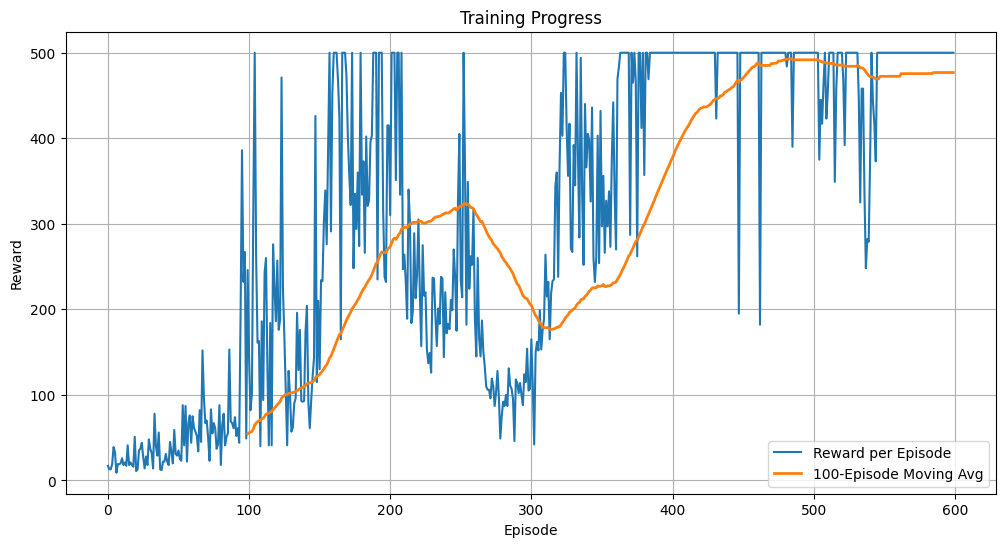

<ipython-input-35-1885a0399452>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value_losses.append(nn.functional.mse_loss(baseline.squeeze(), torch.tensor(R).to(device)))


Episode 10	Average Score: 19.40
Episode 20	Average Score: 20.55
Episode 30	Average Score: 22.13
Episode 40	Average Score: 21.98
Episode 50	Average Score: 25.44
Episode 60	Average Score: 33.57
Episode 70	Average Score: 37.89
Episode 80	Average Score: 47.51
Episode 90	Average Score: 54.33
Episode 100	Average Score: 84.00
Episode 110	Average Score: 117.51
Episode 120	Average Score: 158.18
Episode 130	Average Score: 189.82
Episode 140	Average Score: 217.67
Episode 150	Average Score: 263.13
Episode 160	Average Score: 298.97
Episode 170	Average Score: 326.51
Episode 180	Average Score: 351.81
Episode 190	Average Score: 390.92
Episode 200	Average Score: 401.29
Episode 210	Average Score: 409.99
Episode 220	Average Score: 417.15
Episode 230	Average Score: 432.08
Episode 240	Average Score: 448.71
Episode 250	Average Score: 447.52
Episode 260	Average Score: 454.26
Episode 270	Average Score: 465.53
Episode 280	Average Score: 476.60
Episode 290	Average Score: 464.27
Episode 300	Average Score: 468.80

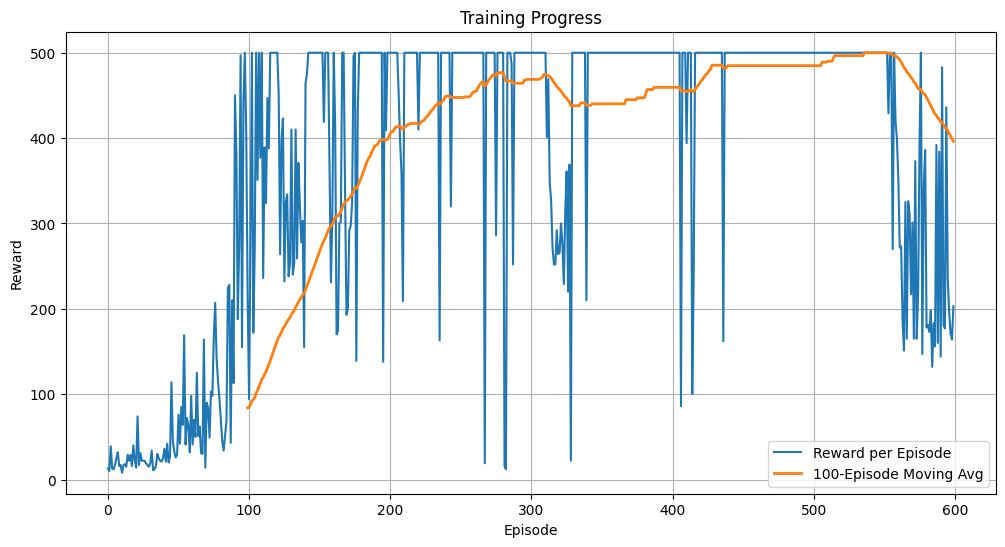

In [38]:
seed = 123
state, _ = env.reset(seed=seed)
env.action_space.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)


state_size = env.observation_space.shape[0]
action_size = env.action_space.n
hidden_size = 128

policy1 = Policy(cartpole_hyperparameters["state_space"], cartpole_hyperparameters["action_space"], cartpole_hyperparameters["h_size"]).to(device)
policy2 = copy.deepcopy(policy1)

policy_optimizer1 = torch.optim.Adam(policy1.parameters(), lr=1e-2)
policy_optimizer2 = torch.optim.Adam(policy2.parameters(), lr=1e-2)

# Istanzia rete valore + ottimizzatore per baseline trainer
value_net = ValueNetwork(state_size, hidden_size).to(device)
value_optimizer = torch.optim.Adam(value_net.parameters(), lr=1e-2)


trainer_no_baseline = ReinforceTrainer(policy1, policy_optimizer1, env, gamma=0.99, max_t=1000)
trainer_with_baseline = ReinforceWithBaselineTrainer(policy2, value_net, policy_optimizer2, value_optimizer,
                                                    env, gamma=0.99, max_t=1000)


scores_no_baseline = trainer_no_baseline.reinforce(cartpole_hyperparameters['n_training_episodes'], print_every=10),
scores_with_baseline = trainer_with_baseline.reinforce(cartpole_hyperparameters['n_training_episodes'], print_every=10)


**The Real Exercise**: Standard practice is to use the state-value function $v(s)$ as a baseline. This is intuitively appealing -- we are more interested in updating out policy for returns that estimate the current **value** worse. Our new update becomes:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha (G_t - \tilde{v}(S_t \mid \mathbf{w})) \frac{\nabla \pi(A_t \mid s, \boldsymbol{\theta})}{\pi(A_t \mid s, \boldsymbol{\theta})} $$

where $\tilde{v}(s \mid \mathbf{w})$ is a **deep neural network** with parameters $w$ that estimates $v_\pi(s)$. What neural network? Typically, we use the **same** network architecture as that of the Policy.

**Your Task**: Modify your implementation to fit a second, baseline network to estimate the value function and use it as **baseline**.

In [ ]:
# Your code here.

-----
## Exercise 3: Going Deeper

As usual, pick **AT LEAST ONE** of the following exercises to complete.

### Exercise 3.1: Solving Lunar Lander with `REINFORCE` (easy)

Use my (or even better, improve on my) implementation of `REINFORCE` to solve the [Lunar Lander Environment](https://gymnasium.farama.org/environments/box2d/lunar_lander/). This environment is a little bit harder than Cartpole, but not much. Make sure you perform the same types of analyses we did during the lab session to quantify and qualify the performance of your agents.

### Exercise 3.2: Solving Cartpole and Lunar Lander with `Deep Q-Learning` (harder)

On policy Deep Reinforcement Learning tends to be **very unstable**. Write an implementation (or adapt an existing one) of `Deep Q-Learning` to solve our two environments (Cartpole and Lunar Lander). To do this you will need to implement a **Replay Buffer** and use a second, slow-moving **target Q-Network** to stabilize learning.

### Exercise 3.3: Solving the OpenAI CarRacing environment (hardest)

Use `Deep Q-Learning` -- or even better, an off-the-shelf implementation of **Proximal Policy Optimization (PPO)** -- to train an agent to solve the [OpenAI CarRacing](https://github.com/andywu0913/OpenAI-GYM-CarRacing-DQN) environment. This will be the most *fun*, but also the most *difficult*. Some tips:

1. Make sure you use the `continuous=False` argument to the environment constructor. This ensures that the action space is **discrete** (we haven't seen how to work with continuous action spaces).
2. Your Q-Network will need to be a CNN. A simple one should do, with two convolutional + maxpool layers, folowed by a two dense layers. You will **definitely** want to use a GPU to train your agents.
3. The observation space of the environment is a single **color image** (a single frame of the game). Most implementations stack multiple frames (e.g. 3) after converting them to grayscale images as an observation.



#### Modifiche all'Ambiente e Preprocessamento delle Osservazioni